<a href="https://colab.research.google.com/github/peony1217-ctrl/Data_Transformation/blob/main/ML_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# ==============================================================================
# Colab Cell 1: 환경 설정 및 라이브러리 로드
# ==============================================================================
import numpy as np
import pandas as pd

# 시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 무시 설정
import warnings
warnings.filterwarnings('ignore')

# K-Means 및 전처리 라이브러리 임포트
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA  # 군집 결과를 2차원으로 시각화하기 위함
from sklearn.metrics import silhouette_score, silhouette_samples  # 실루엣 분석을 위함

In [28]:
# ==============================================================================
# Colab Cell 2: 시각화 설정 (한글 폰트 및 스타일)
# ==============================================================================
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 코랩 환경에서 나눔 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')

# 폰트 설정 및 음수 부호 문제 해결
mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
print("✅ 시각화 환경 설정 완료 (나눔고딕 폰트 적용)")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 시각화 환경 설정 완료 (나눔고딕 폰트 적용)


In [42]:
# ==============================================================================
# Colab Cell 3: 데이터 파일 업로드 (코랩 전용)
# ==============================================================================
from google.colab import files

# 파일 업로드 안내
print("👇 'Online Retail.xlsx' 파일을 업로드해 주세요.")
uploaded = files.upload()

# 업로드된 파일명을 사용하여 파일 경로 설정
file_path = "Online Retail.xlsx"



👇 'Online Retail.xlsx' 파일을 업로드해 주세요.


Saving Online Retail.xlsx to Online Retail (2).xlsx


In [45]:
data = pd.read_excel(file_path)

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [47]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


고객 세그먼테이션 고객 단위로 그룹을 나누는 작업이라서 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요

RFM sementation

RECENCY (R): 가장 최근 상품 구입 일에서 오늘까지의 기간
FREQUENCY (F): 상품 구매 횟수
MONETARY VALUE (M): 총 구매 금액

In [59]:
# ==============================================================================
# Colab Cell 4: RFM 데이터 생성 함수
# ==============================================================================
def get_retail_df(file_path):
    """
    온라인 리테일 데이터를 로드, 전처리하여 RFM 분석의 기초 DataFrame을 반환합니다.
    """
    # 1. 데이터 로드
    retail_df = pd.read_excel(file_path)

    # 2. 데이터 클렌징
    # CustomerID 결측치 제거 (군집화 대상이므로 필수 - 고객 단위로 그룹을 나누는 작업)
    retail_df = retail_df[retail_df['CustomerID'].notnull()]
    # Quantity(수량), UnitPrice(단가) 음수/0 값 제거 (반품/취소 데이터 제외)
    retail_df = retail_df[retail_df['Quantity'] > 0]
    retail_df = retail_df[retail_df['UnitPrice'] > 0]

    # 3. SaleAmount 피처 생성
    # SaleAmount (총 판매 금액, Monetary) 계산
    retail_df['SaleAmount'] = retail_df['Quantity'] * retail_df['UnitPrice']

    # 4. Recency 기준일 설정
    # 데이터 내 '최대 거래일'의 다음 날을 '현재' 시점으로 가정
    NOW = retail_df['InvoiceDate'].max() + pd.Timedelta(days=1)

    # 5. R, F, M 계산
    # CustomerID 기준으로 그룹화하여 집계 함수 적용
    cust_df = retail_df.groupby('CustomerID').agg({
        'InvoiceDate': 'max',  # R: 가장 최근 구매일
        'InvoiceNo': 'count',  # F: 총 거래 횟수
        'SaleAmount': 'sum'     # M: 총 구매 금액
    }).rename(columns = {'InvoiceDate':'Recency_Date',
                         'InvoiceNo':'Frequency',
                         'SaleAmount':'Monetary'})

    # Recency 최종 계산 (기준일 - 마지막 구매일 = 경과 일수)
    cust_df['Recency'] = (NOW - cust_df['Recency_Date']).dt.days

    # CustomerID를 컬럼으로 변환하고, 불필요한 Recency_Date 컬럼 제거
    cust_df = cust_df.reset_index()
    cust_df = cust_df[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

    return cust_df

# 함수 실행: RFM DataFrame 생성
cust_df = get_retail_df(file_path)

cust_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


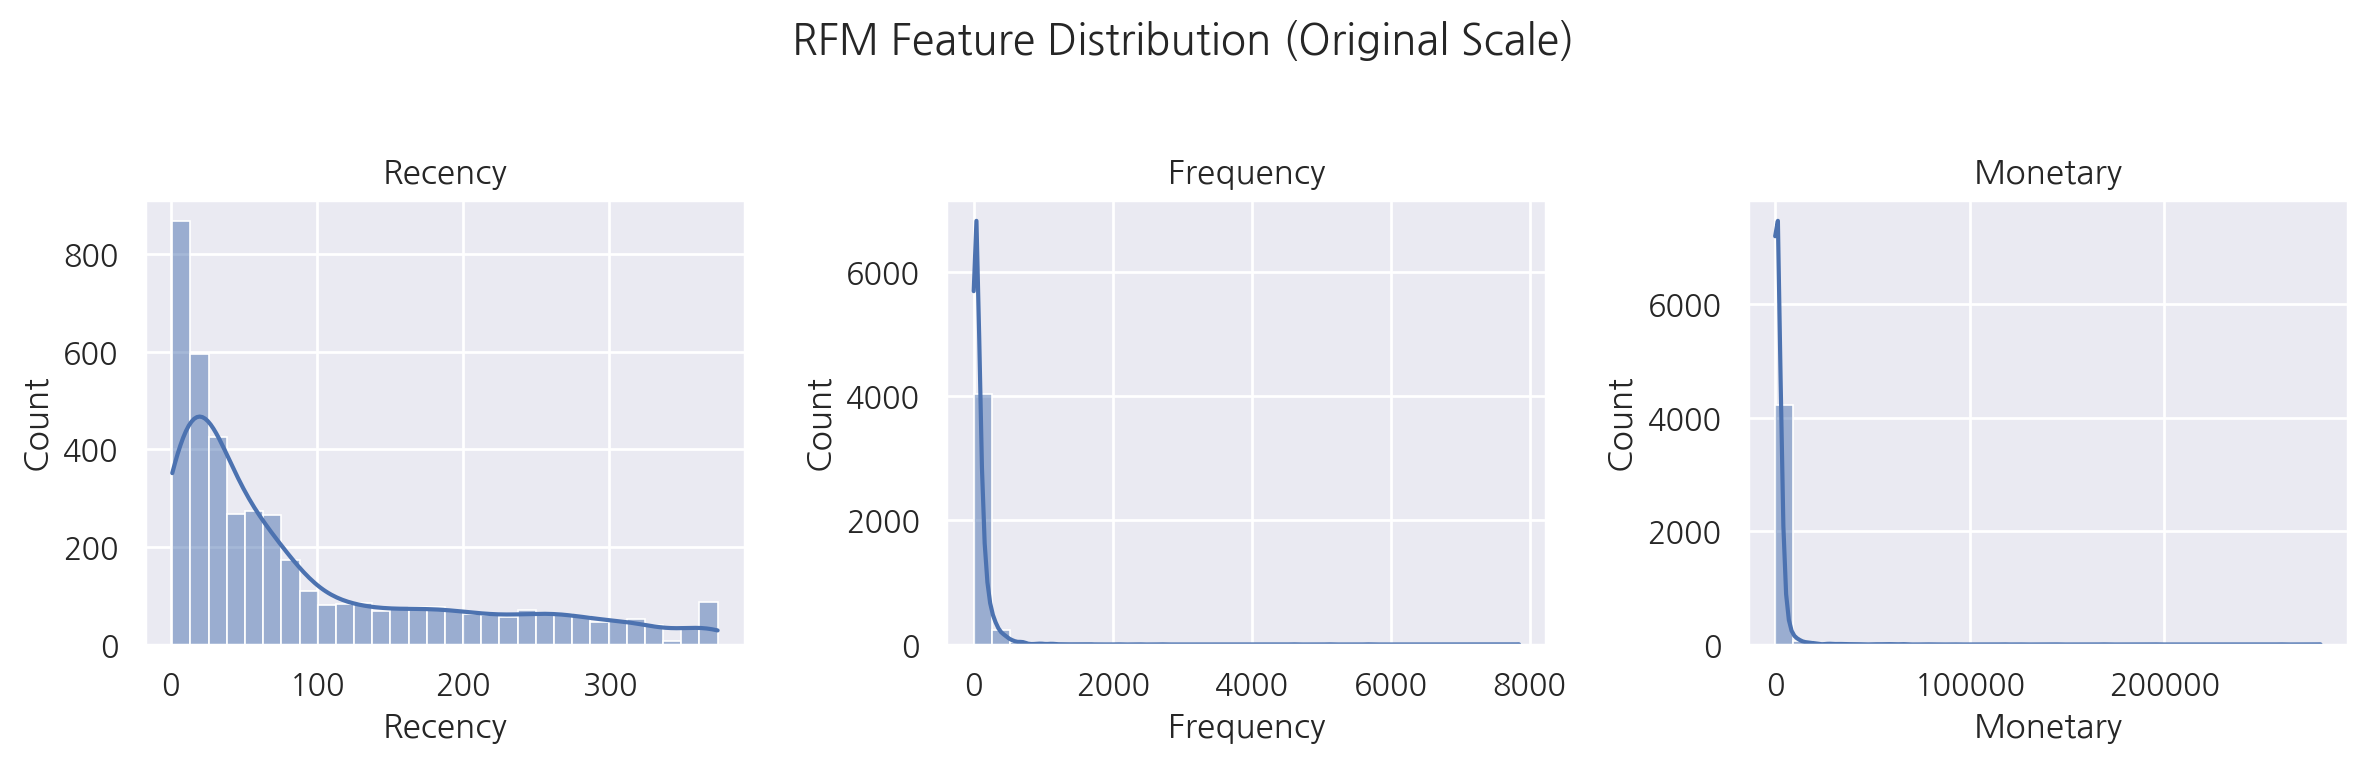

✅ 로그 변환 및 표준 스케일링 완료


In [62]:
# ==============================================================================
# Colab Cell 5: RFM 피처 분포 확인 및 전처리 (기존 코드 유지)
# ==============================================================================

# RFM 피처의 분포를 시각화하여 왜곡 정도 확인
plt.figure(figsize=(12, 4))
plt.suptitle('RFM Feature Distribution (Original Scale)', fontsize=15)

# 히스토그램 시각화 (R, F, M)
for i, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(cust_df[feature], kde=True, bins=30)
    plt.title(feature)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ------------------------------------------------------------------------------
# K-Means를 위한 데이터 전처리: 로그 변환 + 표준 스케일링
# ------------------------------------------------------------------------------

# 1. 로그 변환 (np.log1p): 왜곡된 분포를 정규 분포에 가깝게 만듦
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# 2. 표준 스케일링: 피처의 단위 차이를 제거하여 거리 기반 모델에 적합하게 만듦
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

print("✅ 로그 변환 및 표준 스케일링 완료")



데이터가 한쪽으로 치우친 것으로 확인되고 이는 개인-소매 고객의 주문 건수가 많아서이다.

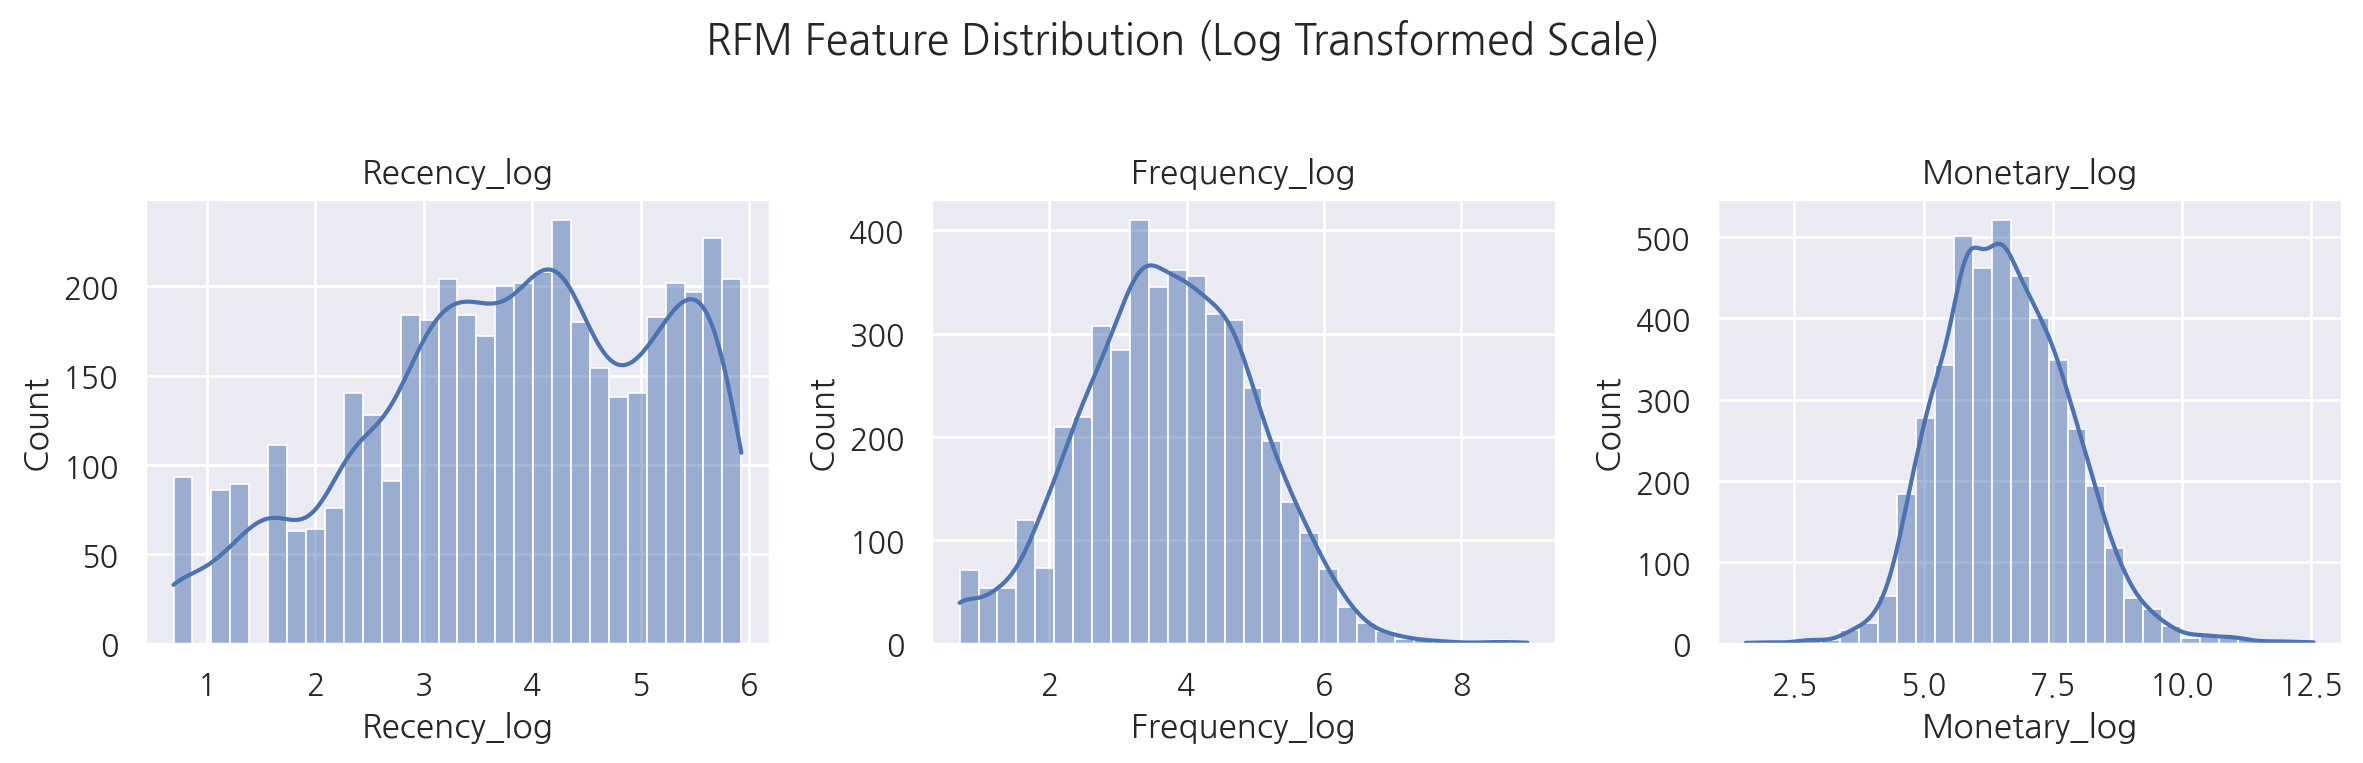

✅ 로그 변환 후 RFM 피처 분포 시각화 완료


In [63]:
# ==============================================================================
# Colab Cell: 로그 변환 후 RFM 피처 분포 시각화
# ==============================================================================

plt.figure(figsize=(12, 4))
plt.suptitle('RFM Feature Distribution (Log Transformed Scale)', fontsize=15)

# 로그 변환된 RFM 피처 시각화 (히스토그램)
for i, feature in enumerate(['Recency_log', 'Frequency_log', 'Monetary_log']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(cust_df[feature], kde=True, bins=30)
    plt.title(feature)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("✅ 로그 변환 후 RFM 피처 분포 시각화 완료")

로그 변환 후 RFM 피처 분포 확인

RFM 피처들이 로그 변환된 후 어떻게 분포가 변화했는지 시각적으로 확인했고, Recency의 로그 변환된 분포가 완벽한 정규 분포는 아니더라도 원본 데이터보다는 훨씬 대칭에 가까워져 K-Means와 같은 거리 기반 모델에 더 적합하도록 정규 분포의 모양을 가지게 되었다.

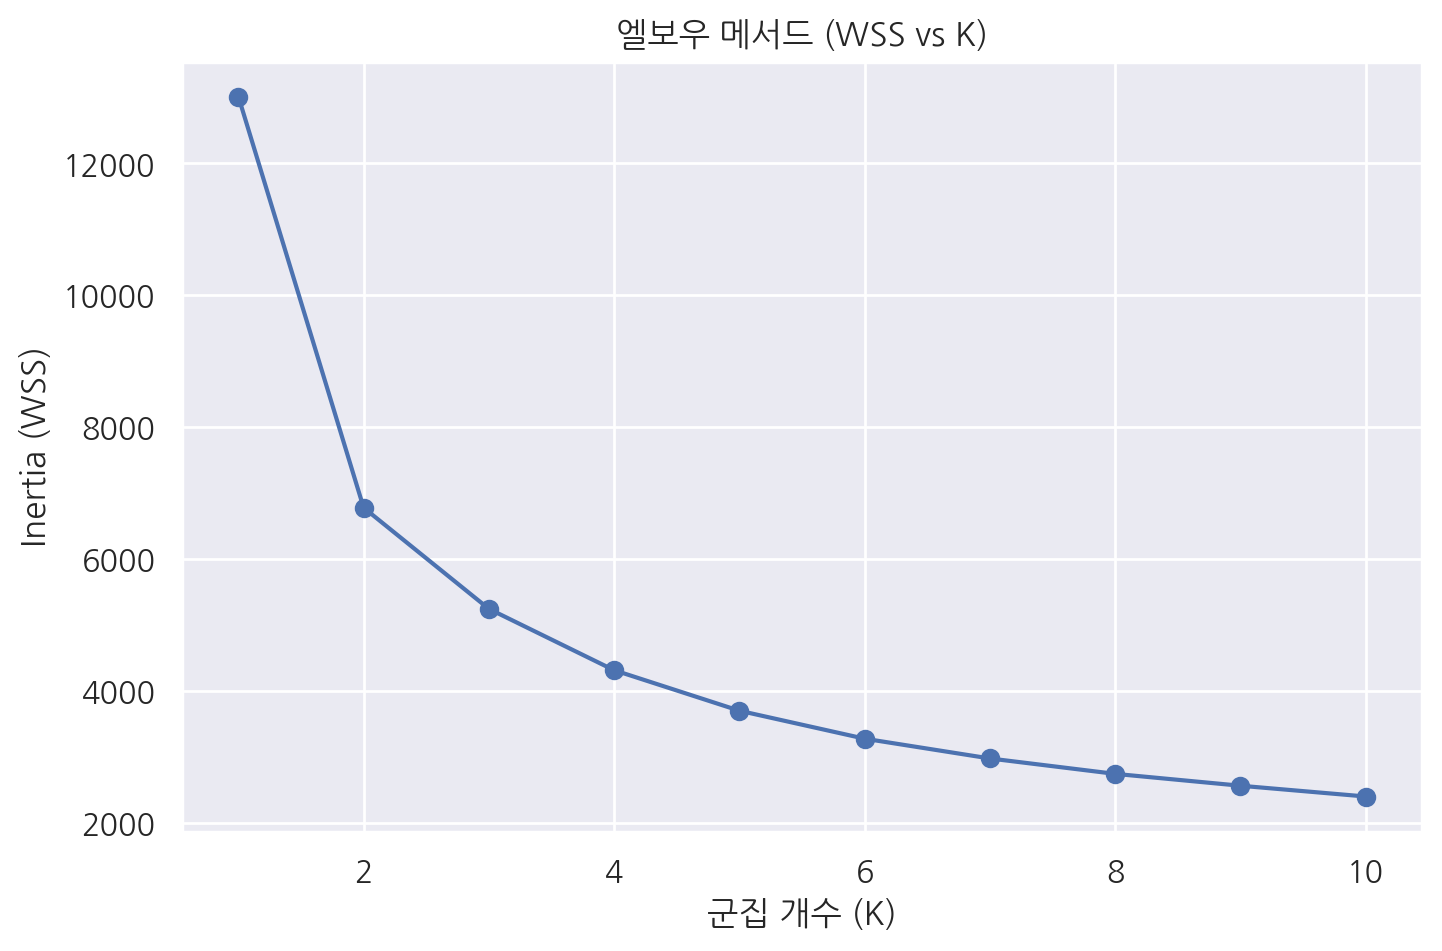

👉 그래프에서 기울기가 완만해지기 시작하는 K 값(예: K=3)을 후보로 선택합니다.


In [50]:
# ==============================================================================
# Colab Cell 6: 엘보우(Elbow) 메서드를 이용한 최적 K 결정
# ==============================================================================
inertia_list = []
max_k = 10

# K=1부터 10까지 K-Means 반복 수행
for k in range(1, max_k + 1):
    # n_init=10 설정으로 초기 중심점 설정에 따른 편차 최소화 (각 반복마다 k 값이 달라짐)
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, random_state=0, n_init=10)
    kmeans.fit(X_features_scaled)
    inertia_list.append(kmeans.inertia_)  # 군집 내 제곱합 (WSS) 기록

# 엘보우 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), inertia_list, marker='o')
plt.title('엘보우 메서드 (WSS vs K)')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia (WSS)')
plt.grid(True)
plt.show()

print("👉 그래프에서 기울기가 완만해지기 시작하는 K 값(예: K=3)을 후보로 선택합니다.")

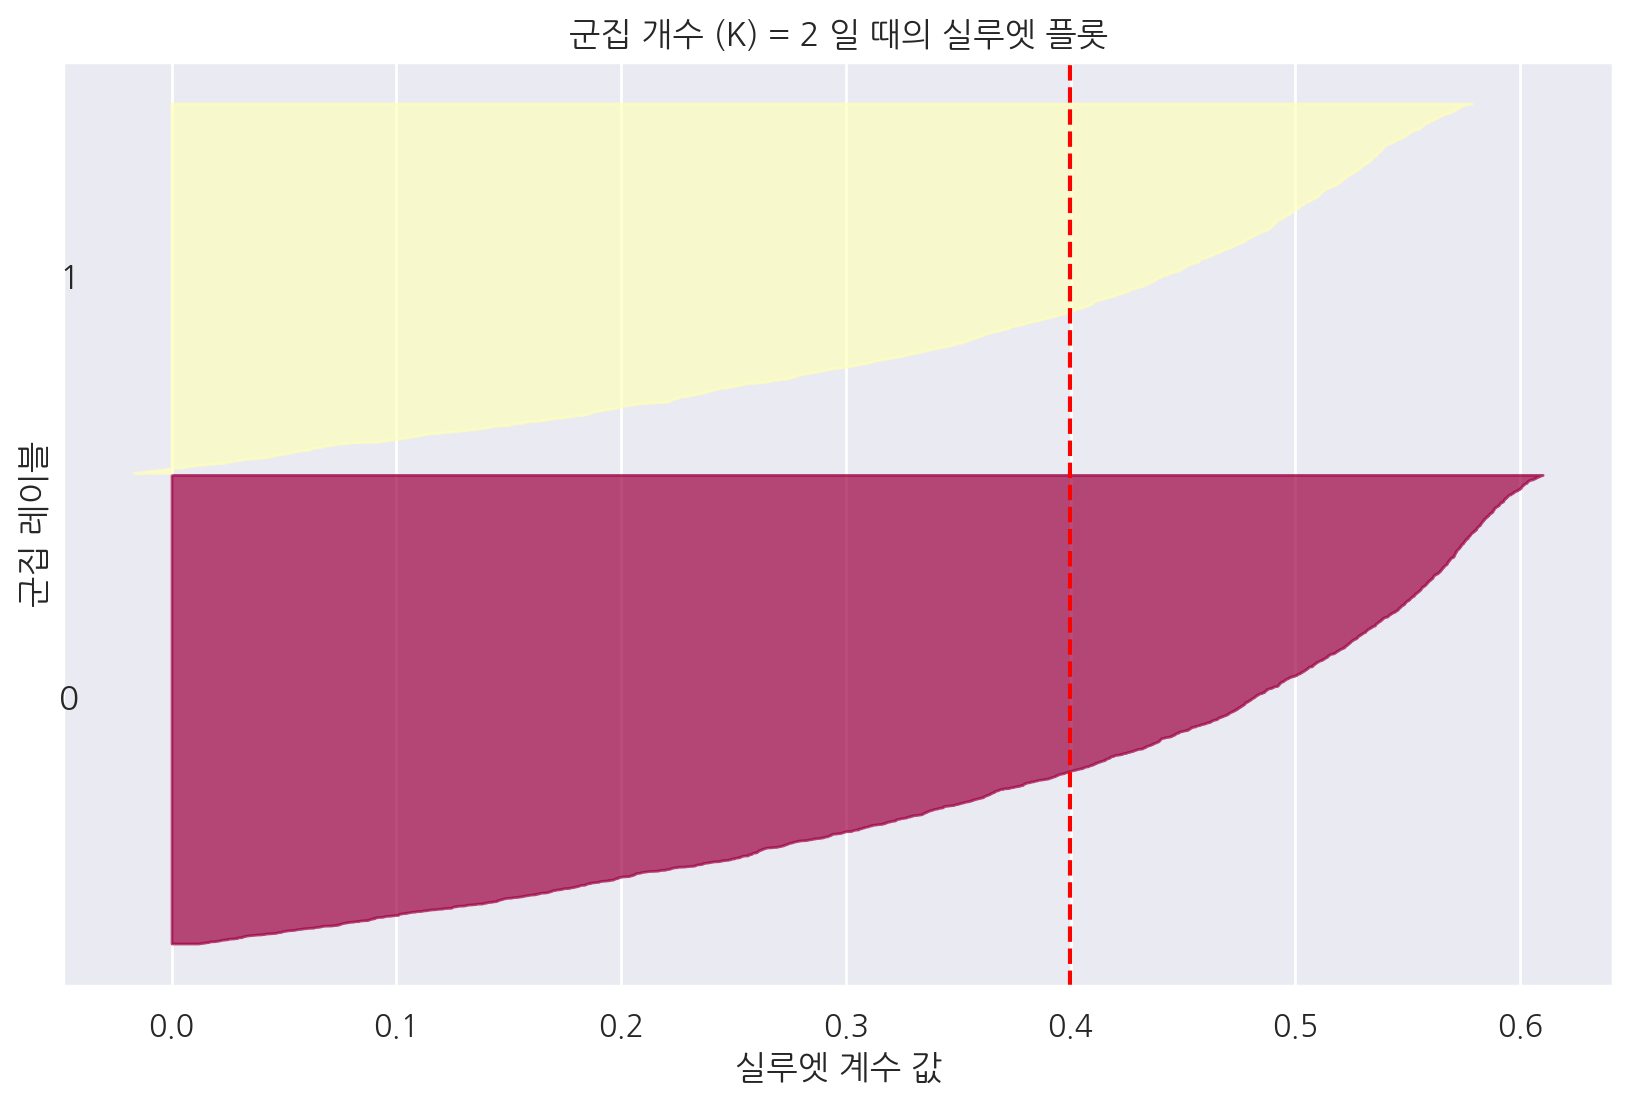

K = 2 일 때, 평균 실루엣 계수: 0.400


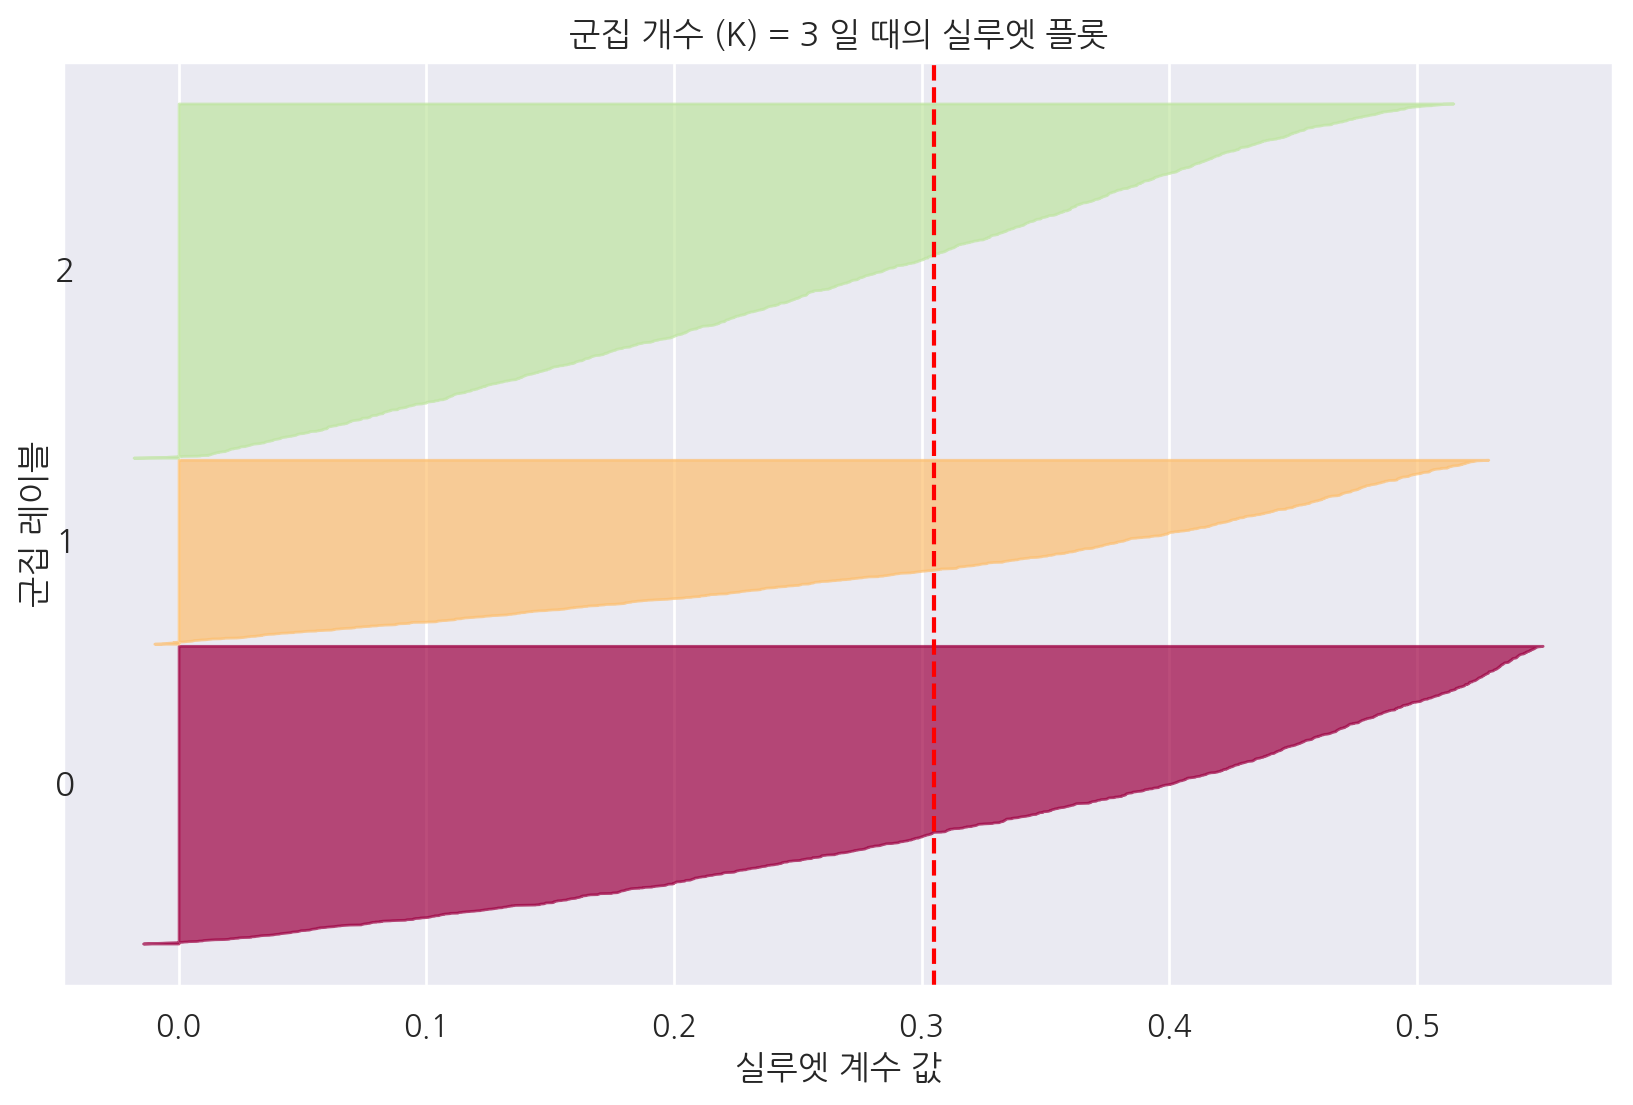

K = 3 일 때, 평균 실루엣 계수: 0.305


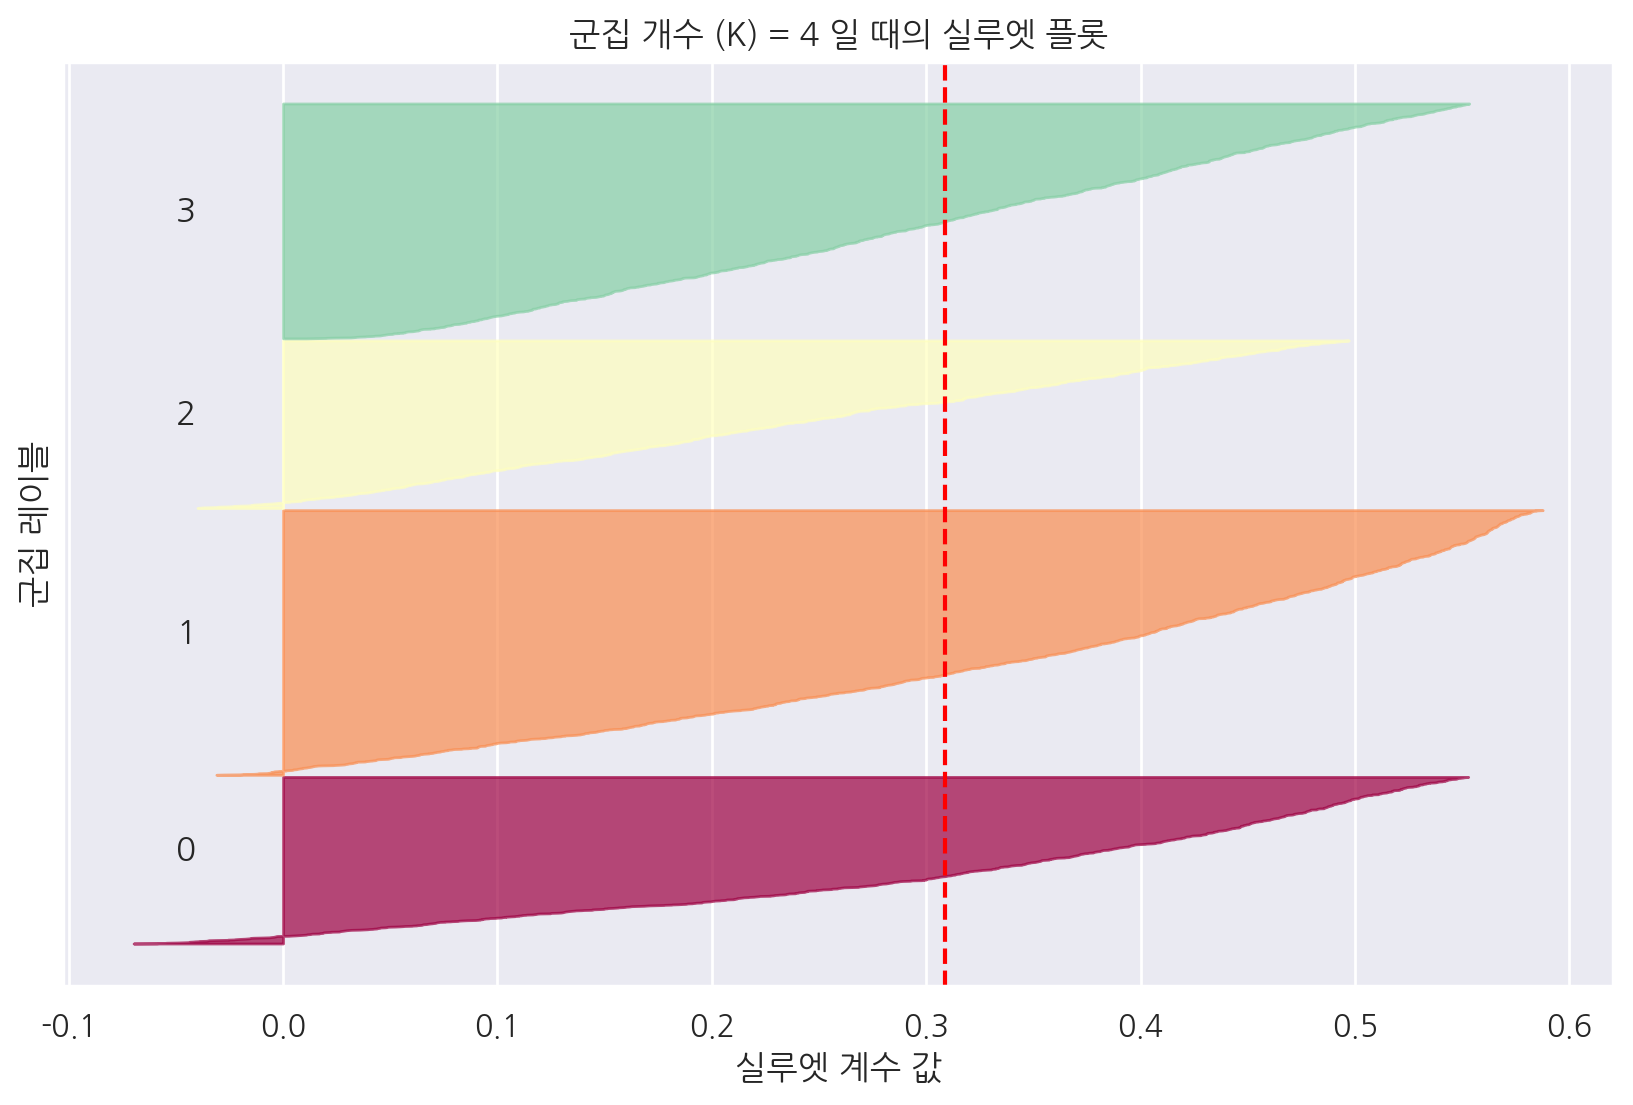

K = 4 일 때, 평균 실루엣 계수: 0.309


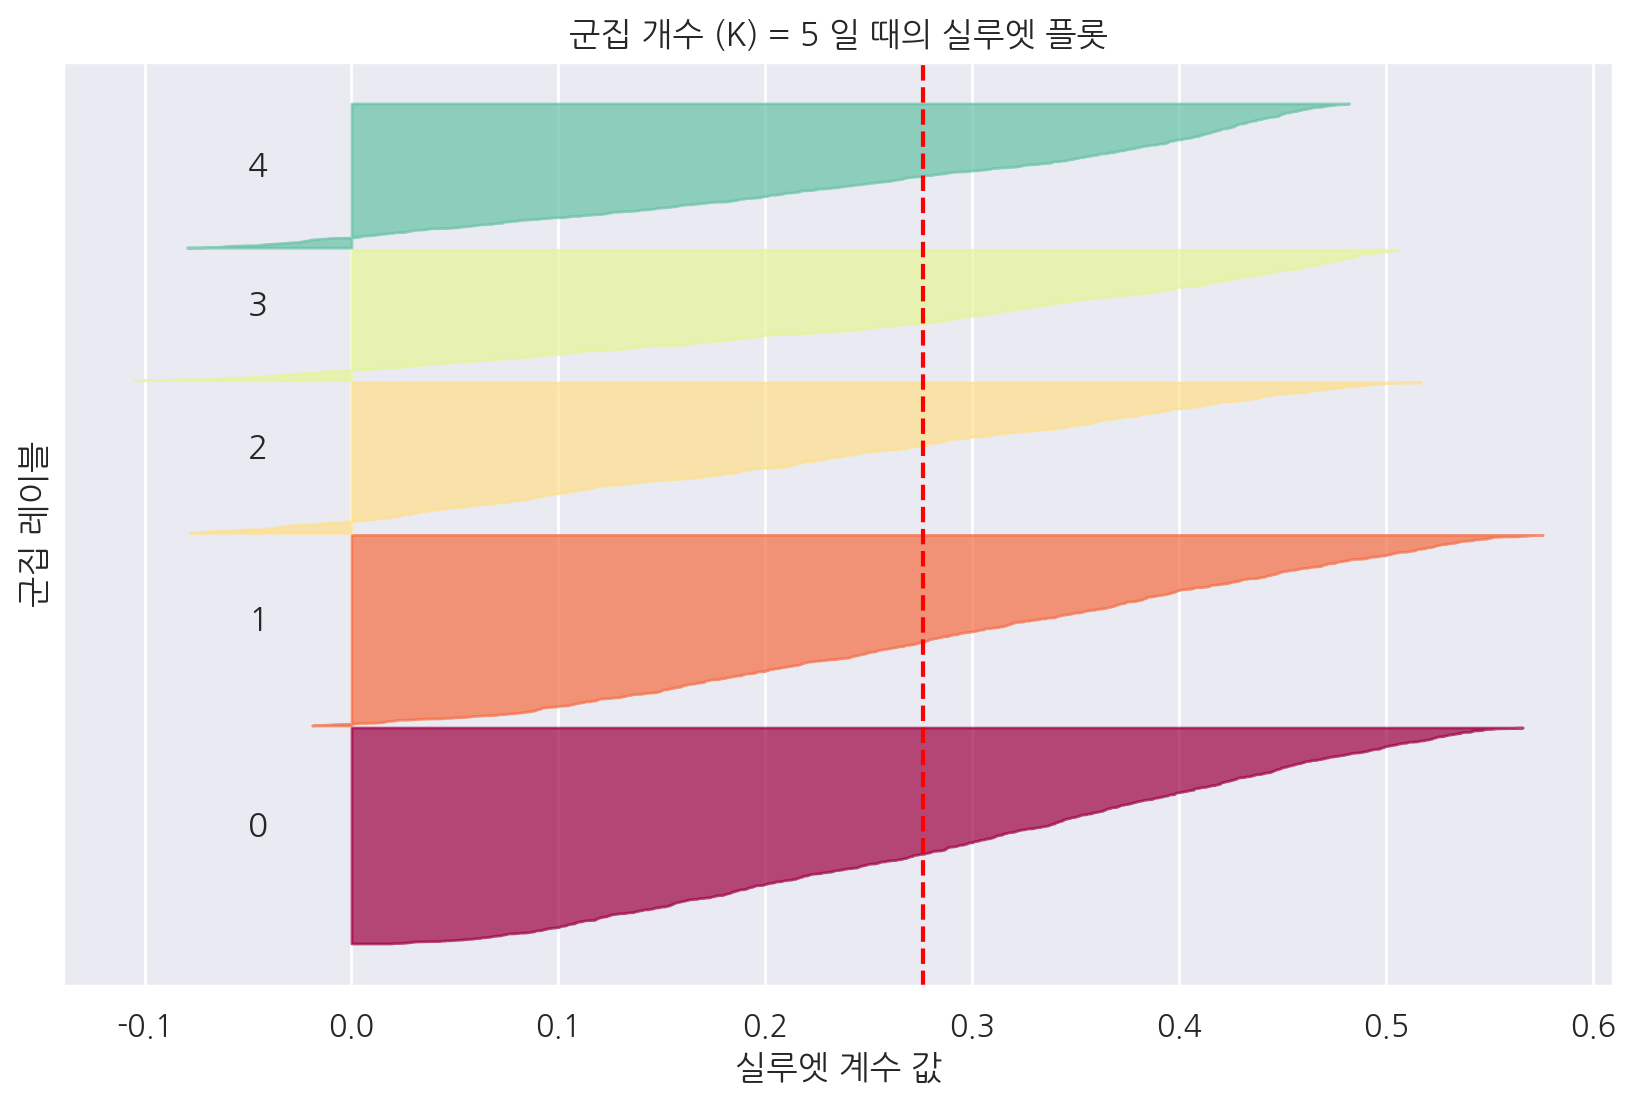

K = 5 일 때, 평균 실루엣 계수: 0.276


In [64]:
# ==============================================================================
# Colab Cell 7: 실루엣 분석을 이용한 최적 K 검증
# ==============================================================================
def visualize_silhouette_analysis(X_features_scaled, n_clusters_list):
    """ 다양한 K 값에 대한 실루엣 플롯과 실루엣 계수 평균을 시각화합니다. """
    for n_clusters in n_clusters_list:
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500,
                        random_state=0, n_init=10)
        cluster_labels = kmeans.fit_predict(X_features_scaled)

        # 실루엣 계수 평균 계산
        silhouette_avg = silhouette_score(X_features_scaled, cluster_labels)
        sample_silhouette_values = silhouette_samples(X_features_scaled, cluster_labels)

        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = mpl.cm.get_cmap("Spectral")(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_title(f"군집 개수 (K) = {n_clusters} 일 때의 실루엣 플롯")
        ax1.set_xlabel("실루엣 계수 값")
        ax1.set_ylabel("군집 레이블")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        plt.show()
        print(f"K = {n_clusters} 일 때, 평균 실루엣 계수: {silhouette_avg:.3f}")

# K=2, 3, 4, 5에 대해 실루엣 분석 실행
visualize_silhouette_analysis(X_features_scaled, [2, 3, 4, 5])



실루엣 점수가 적절하게 높고, 개별 군집의 실루엣 폭이 고른 K 값을 최종 선택해야하는데, 엘보우 그래프 상 3이 엘보우 지점이고, 각 군집당의 면적이 비교적 균등하게 K = 3 일 때, 평균 실루엣 계수: 0.305 인 것으로 선택


================== K-Means (K=3) 최종 결과 분석 ==================

[1] 군집별 RFM 원본 평균값 (Monetary 기준 내림차순):
         Recency  Frequency  Monetary
cluster                              
1          14.14     267.11   6605.43
2          64.78      64.63   1161.20
0         174.02      15.53    303.52


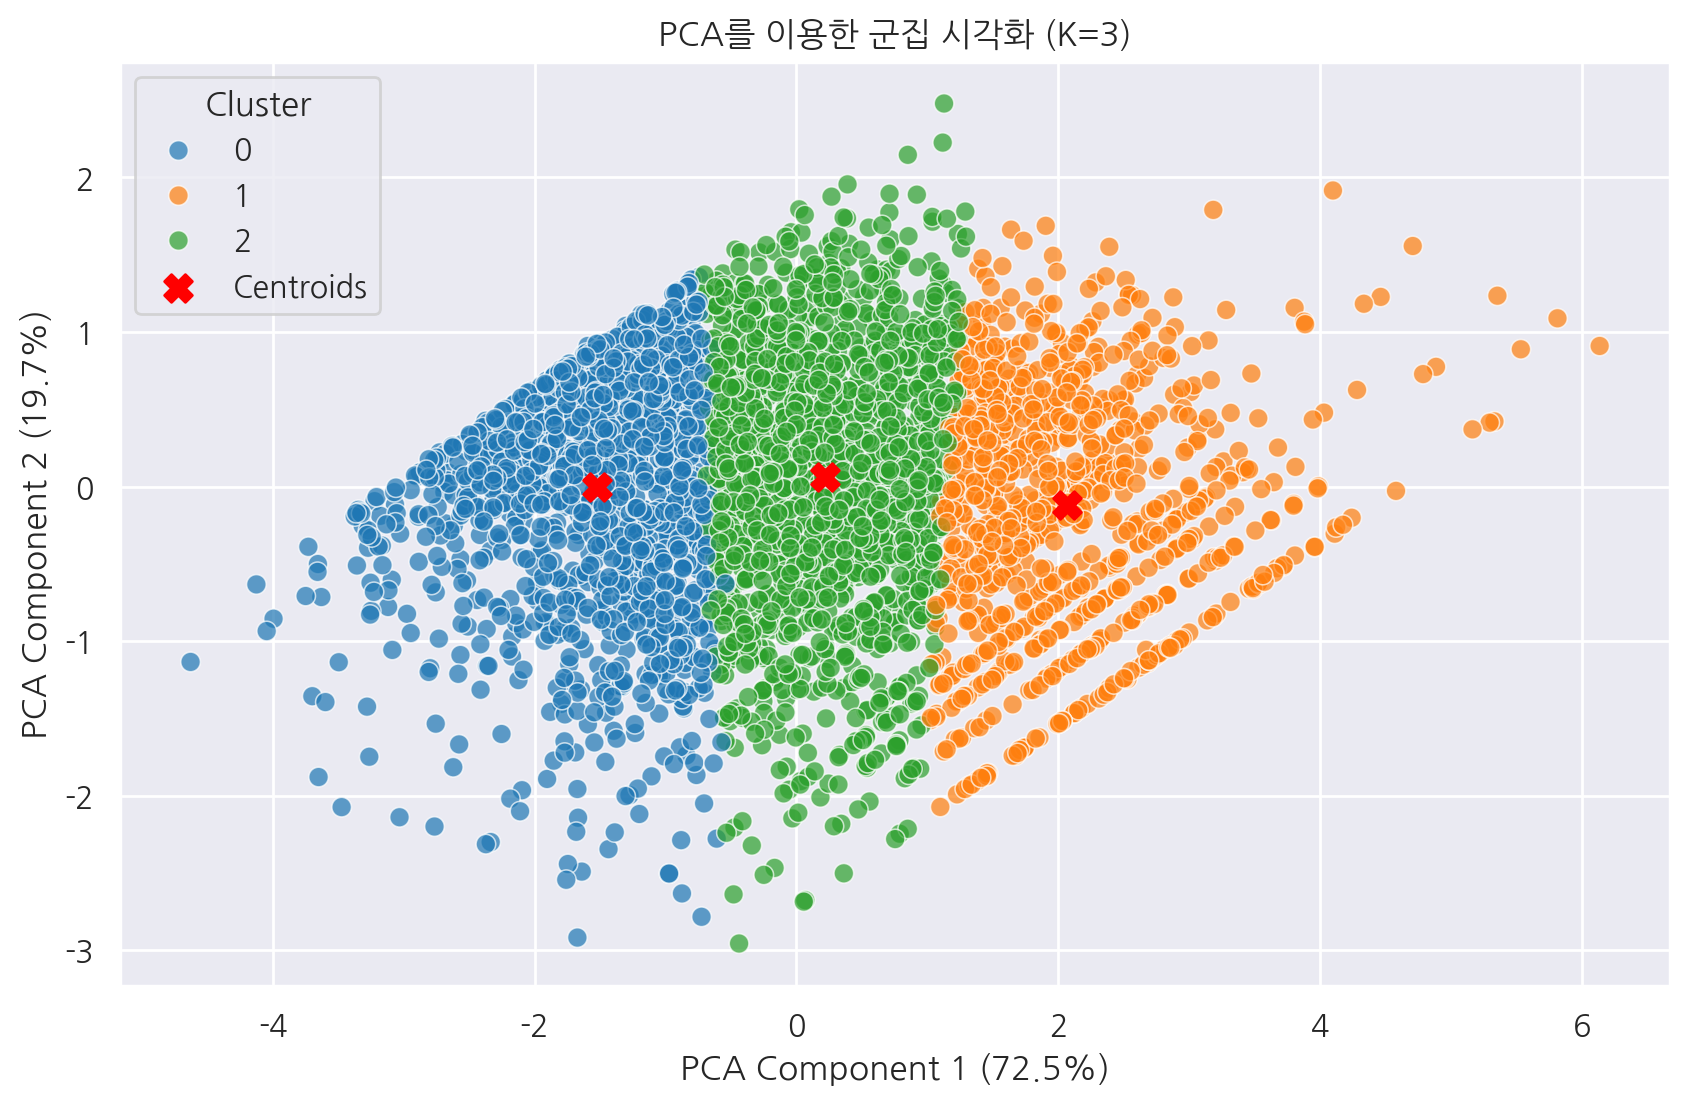

In [67]:
# ==============================================================================
# Colab Cell 8: 최종 K-Means 모델링 및 결과 시각화/분석
# ==============================================================================
def perform_kmeans_clustering(cust_df, X_features_scaled, n_clusters, features=['Recency', 'Frequency', 'Monetary']):
    """
    K-Means 클러스터링을 수행하고 결과를 분석 및 PCA 기반으로 시각화합니다.
    """
    # 최종 K-Means 모델 학습 및 군집 레이블 부여
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, random_state=0, n_init=10)
    cluster_labels = kmeans.fit_predict(X_features_scaled)
    cust_df['cluster'] = cluster_labels

    print(f"================== K-Means (K={n_clusters}) 최종 결과 분석 ==================")

    # 군집별 RFM 원본 평균값 분석 (세그먼트 해석의 핵심)
    print("\n[1] 군집별 RFM 원본 평균값 (Monetary 기준 내림차순):")
    cluster_summary = cust_df.groupby('cluster')[features].mean().sort_values(by='Monetary', ascending=False)
    print(cluster_summary.round(2))

    # ------------------------------------------------------------------------------
    # 2차원 시각화를 위한 PCA 적용
    # ------------------------------------------------------------------------------
    # 3차원(R, F, M) 로그/스케일링 데이터를 2차원으로 축소
    pca = PCA(n_components=2, random_state=0)
    X_pca = pca.fit_transform(X_features_scaled)

    cust_df['pca_x'] = X_pca[:, 0]
    cust_df['pca_y'] = X_pca[:, 1]

    # 시각화 (산점도)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='pca_x', y='pca_y', hue='cluster', data=cust_df,
                    palette=sns.color_palette('tab10', n_clusters),
                    legend='full', alpha=0.7, s=50)

    # 군집 중심점 (Centroids) 시각화: PCA 공간에 투영하여 표시
    centroids_scaled = kmeans.cluster_centers_
    centroids_pca = pca.transform(centroids_scaled)

    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                marker='X', s=100, color='red', label='Centroids', zorder=5)  # zorder로 위에 표시

    plt.title(f'PCA를 이용한 군집 시각화 (K={n_clusters})')
    plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')  # 분산 설명력
    plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

    print("==================================================================")

    return cust_df, cluster_summary, kmeans

# 함수 실행: K-Means 클러스터링 (최적 K=3 적용)
final_cust_df, cluster_characteristics, kmeans_model = perform_kmeans_clustering(
    cust_df.copy(),
    X_features_scaled,
    n_clusters=3
)



K-Means (K=3) 최종 결과 분석

Recency (최근성): 낮을수록 좋음 (최근에 구매함)

Frequency (빈도): 높을수록 좋음 (자주 구매함)

Monetary (금액): 높을수록 좋음 (많이 구매함)

1. Recency가 낮고(최근 구매), Frequency/Monetary가 가장 높음 -> BestVIP 고객

2. Recency, Frequency, Monetary가 모두 중간 정도 - Loyal/Potential 고객

3. Recency가 가장 높고, Frequency/Monetary가 가장 낮음 - Churned / Losing 고객

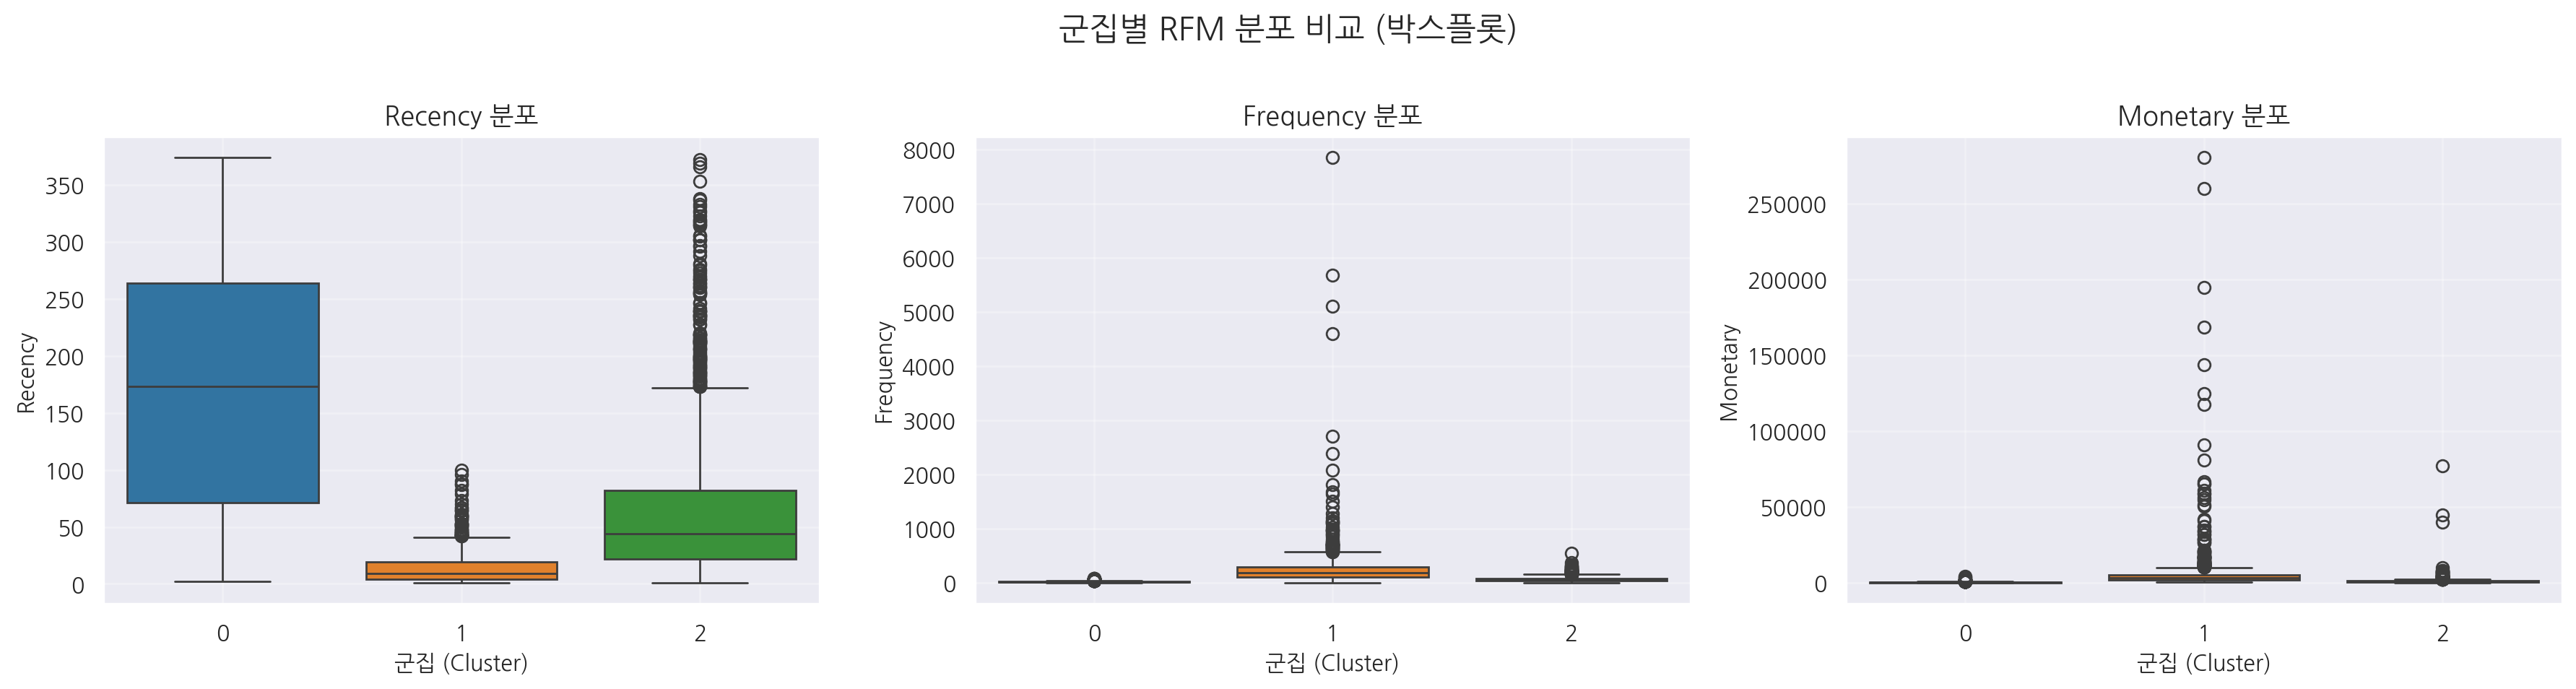


[군집별 RFM 상세 통계]

📊 군집 0:
       Recency  Frequency  Monetary
count  1545.00    1545.00   1545.00
mean    174.02      15.53    303.52
std     108.84      11.99    278.32
min       2.00       1.00      3.75
25%      71.00       7.00    149.29
50%     173.00      13.00    243.76
75%     264.00      21.00    373.94
max     374.00      85.00   4055.72

📊 군집 1:
       Recency  Frequency   Monetary
count   955.00     955.00     955.00
mean     14.14     267.11    6605.43
std      14.73     438.22   18133.61
min       1.00       3.00     469.48
25%       4.00     111.00    1932.86
50%       9.00     180.00    3062.40
75%      19.00     296.00    5196.52
max     100.00    7847.00  280206.02

📊 군집 2:
       Recency  Frequency  Monetary
count  1838.00    1838.00   1838.00
mean     64.78      64.63   1161.20
std      63.22      46.01   2408.13
min       1.00       1.00    120.03
25%      22.00      33.00    538.80
50%      44.00      53.00    826.81
75%      82.00      84.00   1324.42
max     372

In [68]:
# ==============================================================================
# Colab Cell 9: 군집별 상세 통계 및 박스플롯 시각화
# ==============================================================================
"""
📌 추가 기능: 군집별 RFM 분포를 박스플롯으로 시각화하여
각 군집의 분산과 이상치를 직관적으로 파악합니다.
"""

def visualize_cluster_boxplots(cust_df, n_clusters):
    """
    군집별 RFM 피처의 박스플롯을 생성하여 분포와 이상치를 시각화합니다.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('군집별 RFM 분포 비교 (박스플롯)', fontsize=16, fontweight='bold')

    features = ['Recency', 'Frequency', 'Monetary']

    for idx, feature in enumerate(features):
        sns.boxplot(x='cluster', y=feature, data=cust_df,
                   palette=sns.color_palette('tab10', n_clusters), ax=axes[idx])
        axes[idx].set_title(f'{feature} 분포', fontsize=13)
        axes[idx].set_xlabel('군집 (Cluster)', fontsize=11)
        axes[idx].set_ylabel(feature, fontsize=11)
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    # 군집별 상세 통계 출력 (중앙값, 표준편차 포함)
    print("\n[군집별 RFM 상세 통계]")
    print("=" * 80)
    for cluster in sorted(final_cust_df['cluster'].unique()):
        print(f"\n📊 군집 {cluster}:")
        cluster_data = final_cust_df[final_cust_df['cluster'] == cluster][['Recency', 'Frequency', 'Monetary']]
        print(cluster_data.describe().round(2))

# 함수 실행
visualize_cluster_boxplots(final_cust_df, n_clusters=3)


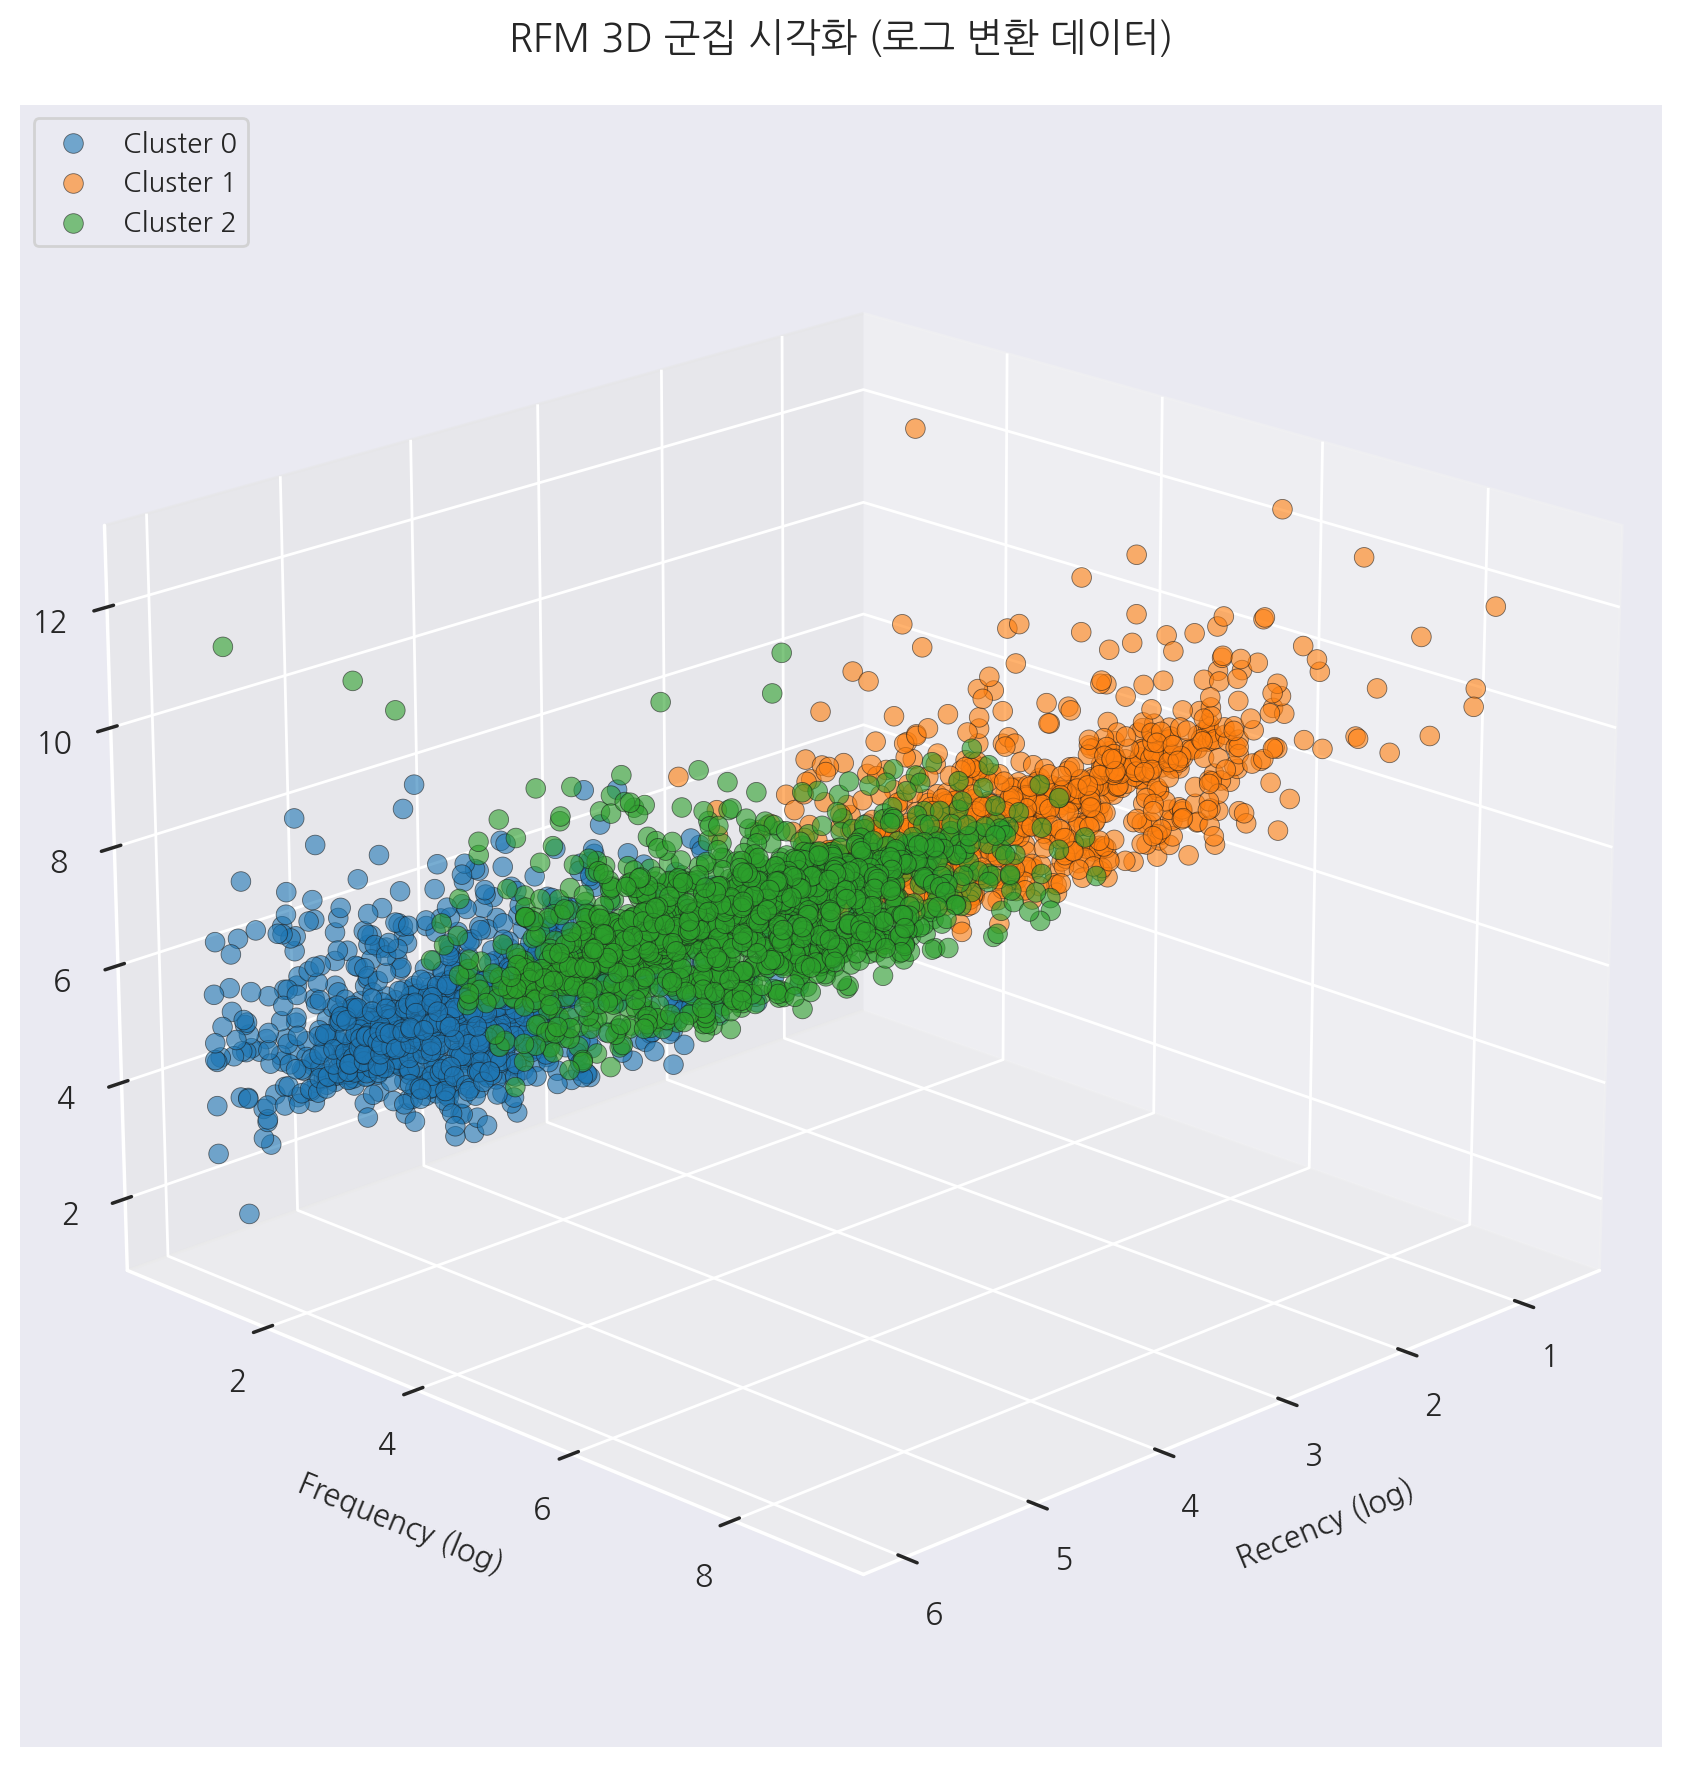

In [54]:
# ==============================================================================
# 🆕 Colab Cell 10: 3D 산점도로 RFM 공간 시각화
# ==============================================================================
"""
📌 추가 기능: 3차원 산점도로 RFM 피처 공간에서 군집이 어떻게 분포하는지
직접 확인합니다. (PCA 없이 원본 로그 변환 데이터 사용)
"""

from mpl_toolkits.mplot3d import Axes3D

def visualize_3d_clusters(cust_df, n_clusters):
    """
    RFM 로그 변환 데이터를 3D 공간에 시각화하여 군집 분포를 확인합니다.
    """
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # 군집별 색상 팔레트
    colors = sns.color_palette('tab10', n_clusters)

    # 군집별로 산점도 그리기
    for cluster in range(n_clusters):
        cluster_data = cust_df[cust_df['cluster'] == cluster]
        ax.scatter(cluster_data['Recency_log'],
                  cluster_data['Frequency_log'],
                  cluster_data['Monetary_log'],
                  c=[colors[cluster]],
                  label=f'Cluster {cluster}',
                  alpha=0.6,
                  s=50,
                  edgecolors='k',
                  linewidth=0.3)

    # 축 레이블 설정
    ax.set_xlabel('Recency (log)', fontsize=11, labelpad=10)
    ax.set_ylabel('Frequency (log)', fontsize=11, labelpad=10)
    ax.set_zlabel('Monetary (log)', fontsize=11, labelpad=10)
    ax.set_title('RFM 3D 군집 시각화 (로그 변환 데이터)', fontsize=14, fontweight='bold', pad=20)

    # 범례 설정
    ax.legend(loc='upper left', fontsize=10)

    # 보기 좋은 각도 설정
    ax.view_init(elev=20, azim=45)

    plt.tight_layout()
    plt.show()

# 함수 실행
visualize_3d_clusters(final_cust_df, n_clusters=3)


[군집별 고객 수 및 매출 기여도 분석]
         Customer_Count  Total_Revenue  Customer_Ratio(%)  Revenue_Ratio(%)
cluster                                                                    
1                   955    6308188.070              22.01             70.79
2                  1838    2134281.773              42.37             23.95
0                  1545     468938.061              35.62              5.26


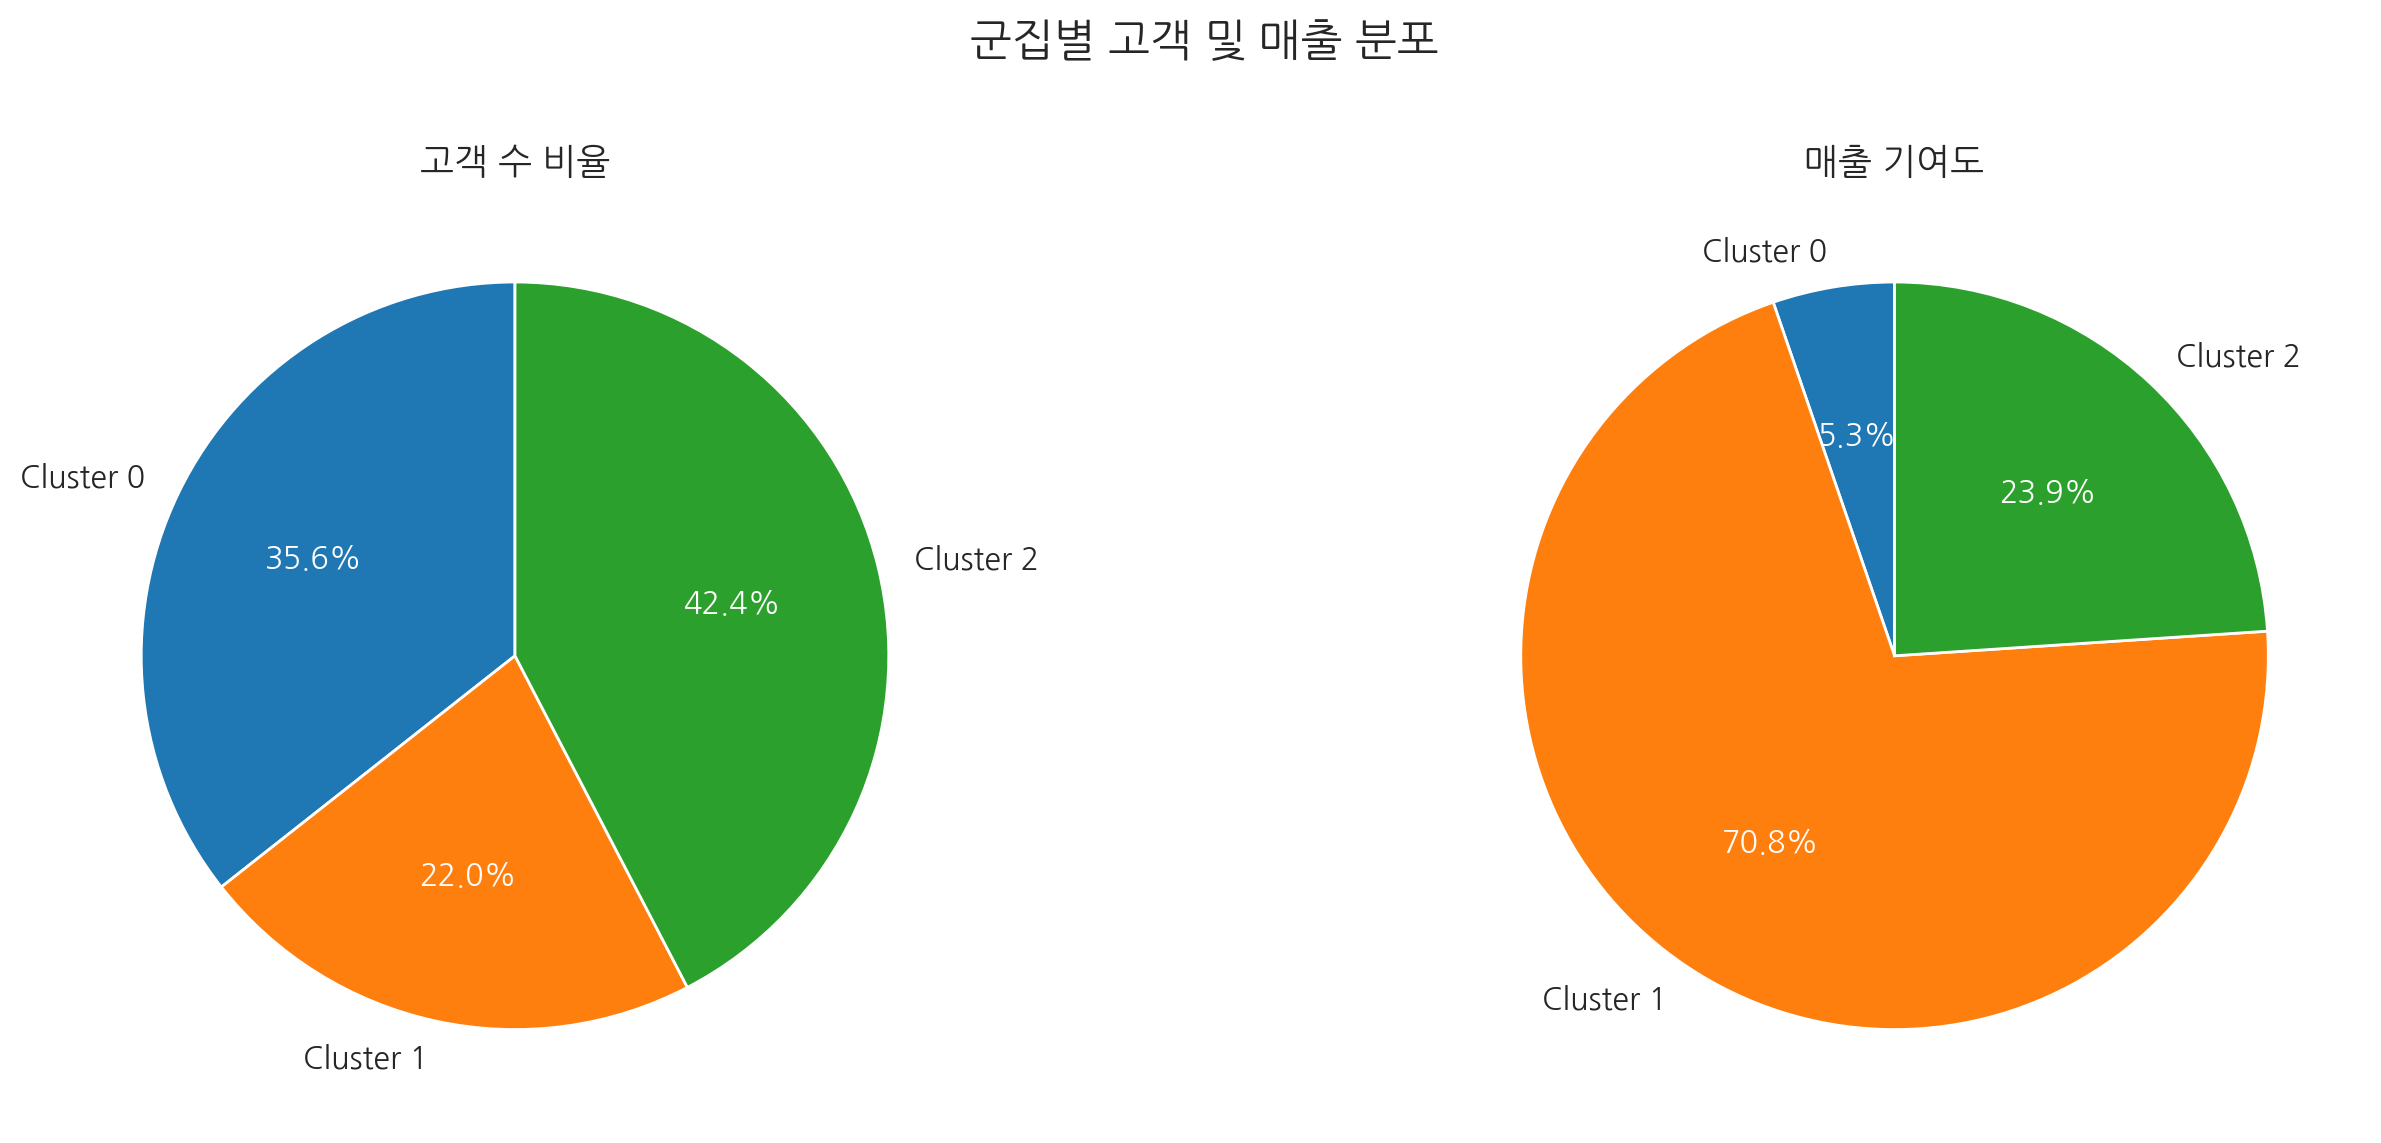


[파이 차트 색상 가이드]
🎨 Cluster 0 (색상 0번): 고객 35.6%, 매출 5.3%
🎨 Cluster 1 (색상 1번): 고객 22.0%, 매출 70.8%
🎨 Cluster 2 (색상 2번): 고객 42.4%, 매출 23.9%


In [75]:
# ==============================================================================
# Colab Cell 12: 군집별 고객 수 및 매출 기여도 분석
# ==============================================================================

def analyze_cluster_contribution(cust_df, n_clusters):
    """
    군집별 고객 수와 매출 기여도를 분석하고 시각화합니다.
    (수정: 파이 차트 색상과 군집 번호를 정확히 일치시킴)
    """
    # 군집별 고객 수 및 총 매출 계산
    cluster_stats = cust_df.groupby('cluster').agg({
        'CustomerID': 'count',  # 고객 수
        'Monetary': 'sum'        # 총 매출
    }).rename(columns={'CustomerID': 'Customer_Count', 'Monetary': 'Total_Revenue'})

    # 비율 계산
    cluster_stats['Customer_Ratio(%)'] = (cluster_stats['Customer_Count'] / cluster_stats['Customer_Count'].sum() * 100).round(2)
    cluster_stats['Revenue_Ratio(%)'] = (cluster_stats['Total_Revenue'] / cluster_stats['Total_Revenue'].sum() * 100).round(2)

    # Monetary 기준으로 정렬 (출력용)
    cluster_stats_sorted = cluster_stats.sort_values(by='Total_Revenue', ascending=False)

    print("\n[군집별 고객 수 및 매출 기여도 분석]")
    print("=" * 80)
    print(cluster_stats_sorted)

    # ------------------------------------------------------------------------------
    # 시각화: 파이 차트 (고객 수 비율 vs 매출 비율)
    # ------------------------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('군집별 고객 및 매출 분포', fontsize=16, fontweight='bold')

    # 색상 팔레트 생성 (Cluster 0=색상0, Cluster 1=색상1, Cluster 2=색상2)
    colors = sns.color_palette('tab10', n_clusters)

    # 군집 번호 순서로 정렬 (0, 1, 2)하여 색상과 매칭
    cluster_stats_ordered = cluster_stats.sort_index()

    # 각 군집에 대응하는 색상 리스트 생성
    cluster_colors = [colors[i] for i in cluster_stats_ordered.index]

    # 고객 수 비율 파이 차트
    wedges1, texts1, autotexts1 = axes[0].pie(
        cluster_stats_ordered['Customer_Count'],
        labels=[f'Cluster {i}' for i in cluster_stats_ordered.index],
        autopct='%1.1f%%',
        startangle=90,
        colors=cluster_colors  # 군집 번호와 일치하는 색상 사용
    )
    axes[0].set_title('고객 수 비율', fontsize=13)

    # 매출 비율 파이 차트
    wedges2, texts2, autotexts2 = axes[1].pie(
        cluster_stats_ordered['Total_Revenue'],
        labels=[f'Cluster {i}' for i in cluster_stats_ordered.index],
        autopct='%1.1f%%',
        startangle=90,
        colors=cluster_colors  # 동일한 색상 사용
    )
    axes[1].set_title('매출 기여도', fontsize=13)

    # 텍스트 가독성 향상
    for autotext in autotexts1 + autotexts2:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_weight('bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    # ------------------------------------------------------------------------------
    # 추가: 군집별 색상 가이드 출력
    # ------------------------------------------------------------------------------
    print("\n[파이 차트 색상 가이드]")
    print("=" * 80)
    for i in cluster_stats_ordered.index:
        # 해당 군집의 특성 간단히 표시
        stats = cluster_stats_ordered.loc[i]
        print(f"🎨 Cluster {i} (색상 {i}번): "
              f"고객 {stats['Customer_Ratio(%)']:.1f}%, "
              f"매출 {stats['Revenue_Ratio(%)']:.1f}%")

    return cluster_stats_sorted

# 함수 실행
cluster_contribution = analyze_cluster_contribution(final_cust_df, n_clusters=3)


각 군집이 전체 고객 수와 매출에서 차지하는 비중을 분석하여 비즈니스 우선순위를 결정하는 데 도움을 준다.

In [76]:
# ==============================================================================
# 🆕 Colab Cell 12: 신규 고객 군집 예측 함수
# ==============================================================================
"""
📌 추가 기능: 새로운 고객의 RFM 값을 입력받아 어느 군집에 속하는지 예측합니다.
실무에서 신규 고객을 기존 세그먼트에 자동 할당할 때 유용합니다.
"""

def predict_customer_cluster(recency, frequency, monetary, scaler, kmeans_model):
    """
    신규 고객의 RFM 값을 받아 군집을 예측합니다.

    Parameters:
    -----------
    recency : int
        최근 구매 후 경과 일수
    frequency : int
        총 구매 횟수
    monetary : float
        총 구매 금액
    scaler : StandardScaler
        학습에 사용된 스케일러 객체
    kmeans_model : KMeans
        학습된 K-Means 모델 객체

    Returns:
    --------
    predicted_cluster : int
        예측된 군집 번호
    """
    # 1. 로그 변환
    rfm_log = np.array([[np.log1p(recency), np.log1p(frequency), np.log1p(monetary)]])

    # 2. 표준 스케일링 (학습 시 사용한 scaler 사용)
    rfm_scaled = scaler.transform(rfm_log)

    # 3. 군집 예측
    predicted_cluster = kmeans_model.predict(rfm_scaled)[0]

    return predicted_cluster

# 예시: 신규 고객 3명의 군집 예측
print("\n[신규 고객 군집 예측 예시]")
print("=" * 80)

new_customers = [
    {'Recency': 10, 'Frequency': 50, 'Monetary': 5000},   # VIP 고객 예상
    {'Recency': 100, 'Frequency': 10, 'Monetary': 800},   # 일반 고객 예상
    {'Recency': 300, 'Frequency': 2, 'Monetary': 150}     # 이탈 위험 고객 예상
]

for i, customer in enumerate(new_customers, 1):
    cluster = predict_customer_cluster(
        customer['Recency'],
        customer['Frequency'],
        customer['Monetary'],
        scaler,
        kmeans_model
    )
    print(f"신규 고객 {i}: R={customer['Recency']}, F={customer['Frequency']}, M={customer['Monetary']}")
    print(f"  → 예측된 군집: Cluster {cluster}\n")


[신규 고객 군집 예측 예시]
신규 고객 1: R=10, F=50, M=5000
  → 예측된 군집: Cluster 1

신규 고객 2: R=100, F=10, M=800
  → 예측된 군집: Cluster 0

신규 고객 3: R=300, F=2, M=150
  → 예측된 군집: Cluster 0



In [57]:
# ==============================================================================
# 🆕 Colab Cell 13: [업그레이드 5] 군집별 마케팅 전략 제안
# ==============================================================================
"""
📌 추가 기능: RFM 군집 분석 결과를 바탕으로 각 군집에 적합한
마케팅 전략을 자동으로 제안합니다.
"""

def suggest_marketing_strategy(cluster_summary):
    """
    군집별 RFM 특성을 분석하여 마케팅 전략을 제안합니다.
    """
    print("\n[군집별 마케팅 전략 제안]")
    print("=" * 80)

    # Monetary 기준으로 정렬된 cluster_summary 사용
    sorted_clusters = cluster_summary.sort_values(by='Monetary', ascending=False)

    strategies = []

    for idx, (cluster, row) in enumerate(sorted_clusters.iterrows()):
        recency = row['Recency']
        frequency = row['Frequency']
        monetary = row['Monetary']

        print(f"\n🎯 군집 {cluster} (Cluster {cluster})")
        print(f"   R: {recency:.1f}일, F: {frequency:.1f}회, M: {monetary:.1f}원")

        # 군집 특성에 따른 전략 제안
        if idx == 0:  # 가장 높은 Monetary → VIP 고객
            strategy = """
   💎 [VIP/Best 고객군]
   • 특성: 최근 구매 이력이 있고, 구매 빈도와 금액이 가장 높음
   • 전략:
     - VIP 전용 혜택 및 프리미엄 서비스 제공
     - 신제품 출시 시 우선 구매 기회 제공
     - 개인화된 맞춤형 상품 추천 및 큐레이션
     - 감사 이벤트 및 로열티 프로그램 강화
     - 상위 1% 고객 대상 비공개 프로모션 진행
"""
        elif idx == 1: # 두 번째로 높은 Monetary → Loyal/Potential 고객
            strategy = """
   🌟 [Loyal/Potential 고객군]
   • 특성: 적당히 최근 구매 이력이 있고, 구매 빈도와 금액이 중간 정도
   • 전략:
     - 꾸준한 구매를 유도하는 할인쿠폰/프로모션 제공
     - 관심사 기반의 상품 추천 (교차 판매/상향 판매)
     - 다음 등급(VIP)으로의 상향 유도를 위한 목표 설정 및 인센티브 제공
     - 구매 시 리뷰 작성 유도 및 포인트 지급
"""
        else: # 가장 낮은 Monetary → Churned/Losing 고객
            strategy = """
   🚨 [Churned/Losing 고객군]
   • 특성: 구매 이력이 오래되었고, 구매 빈도와 금액이 가장 낮음 (이탈 가능성 높음)
   • 전략:
     - 재구매를 유도하는 강력한 할인 또는 특별 혜택 (예: 첫 구매 할인율 이상)
     - 이탈 방지 서베이/피드백 요청 (고객 불편 사항 파악)
     - 소멸 예정 포인트 안내 및 사용 독려
     - 새로운 제품이나 서비스에 대한 정보 제공
     - 고객센터 통한 1:1 맞춤 상담 제공
"""
        print(strategy)
        strategies.append({'cluster': cluster, 'strategy': strategy})

    return strategies

# 함수 실행
marketing_strategies = suggest_marketing_strategy(cluster_characteristics)


[군집별 마케팅 전략 제안]

🎯 군집 1 (Cluster 1)
   R: 14.1일, F: 267.1회, M: 6605.4원

   💎 [VIP/Best 고객군]
   • 특성: 최근 구매 이력이 있고, 구매 빈도와 금액이 가장 높음
   • 전략:
     - VIP 전용 혜택 및 프리미엄 서비스 제공
     - 신제품 출시 시 우선 구매 기회 제공
     - 개인화된 맞춤형 상품 추천 및 큐레이션
     - 감사 이벤트 및 로열티 프로그램 강화
     - 상위 1% 고객 대상 비공개 프로모션 진행


🎯 군집 2 (Cluster 2)
   R: 64.8일, F: 64.6회, M: 1161.2원

   🌟 [Loyal/Potential 고객군]
   • 특성: 적당히 최근 구매 이력이 있고, 구매 빈도와 금액이 중간 정도
   • 전략:
     - 꾸준한 구매를 유도하는 할인쿠폰/프로모션 제공
     - 관심사 기반의 상품 추천 (교차 판매/상향 판매)
     - 다음 등급(VIP)으로의 상향 유도를 위한 목표 설정 및 인센티브 제공
     - 구매 시 리뷰 작성 유도 및 포인트 지급


🎯 군집 0 (Cluster 0)
   R: 174.0일, F: 15.5회, M: 303.5원

   🚨 [Churned/Losing 고객군]
   • 특성: 구매 이력이 오래되었고, 구매 빈도와 금액이 가장 낮음 (이탈 가능성 높음)
   • 전략:
     - 재구매를 유도하는 강력한 할인 또는 특별 혜택 (예: 첫 구매 할인율 이상)
     - 이탈 방지 서베이/피드백 요청 (고객 불편 사항 파악)
     - 소멸 예정 포인트 안내 및 사용 독려
     - 새로운 제품이나 서비스에 대한 정보 제공
     - 고객센터 통한 1:1 맞춤 상담 제공

